In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as pyplt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, PowerTransformer

In [2]:
og_df = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')
og_df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [3]:
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
og_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
for col in og_df:
    if og_df[col].nunique() < 10:
        print(og_df[col].value_counts())
        print("\n")

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


0    4612
1     498
Name: hypertension, dtype: int64


0    4834
1     276
Name: heart_disease, dtype: int64


Yes    3353
No     1757
Name: ever_married, dtype: int64


Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


0    4861
1     249
Name: stroke, dtype: int64




In [6]:
#drop id column due to its irrelevance regarding stroke prediction
df_1 = og_df.drop("id", axis=1)
df_1.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [7]:
index = df_1.index[df_1["gender"] == "Other"]
print(df_1.loc[index])

#removed the other gender since there is only one entry, leading to unnecessary complexity
df_2 = df_1.drop(index)

     gender   age  hypertension  heart_disease ever_married work_type  \
3116  Other  26.0             0              0           No   Private   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
3116          Rural             143.33  22.4  formerly smoked       0  


In [8]:
#replaced NaN values in the bmi column with the average bmi
average_bmi = df_2["bmi"].mean()
df_2["bmi"].fillna(average_bmi, inplace=True)

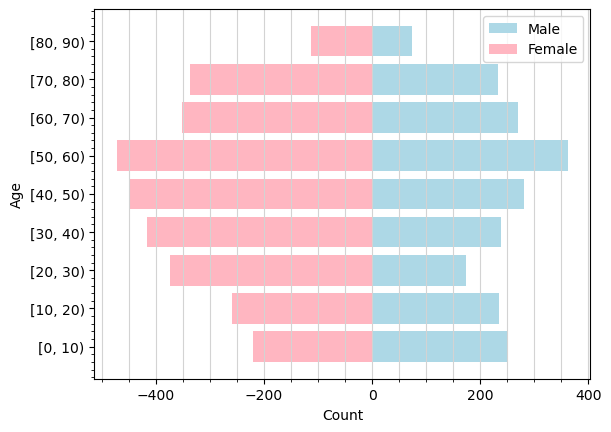

In [9]:
# Defined the age bins
bins = range(0, int(df_2["age"].max()) + 10, 10)

# Add a new column "age_group" to the DataFrame representing the age group of each person
df_2["age_group"] = pd.cut(df_2["age"], bins, right=False)

# Group by "age_group" and "gender" and get the size of each group
grouped = df_2.groupby(["age_group", "gender"]).size().unstack()


# Plot the pyramid chart
fig, ax = pyplt.subplots()

ax.barh(grouped.index.astype(str), grouped["Male"], color='lightblue', label="Male")
ax.barh(grouped.index.astype(str), -grouped["Female"], color='lightpink', label="Female")

ax.legend()
ax.minorticks_on()

ax.grid(True, axis="x", color="lightgray", which="both")

pyplt.xlabel("Count")
pyplt.ylabel("Age")

pyplt.show()

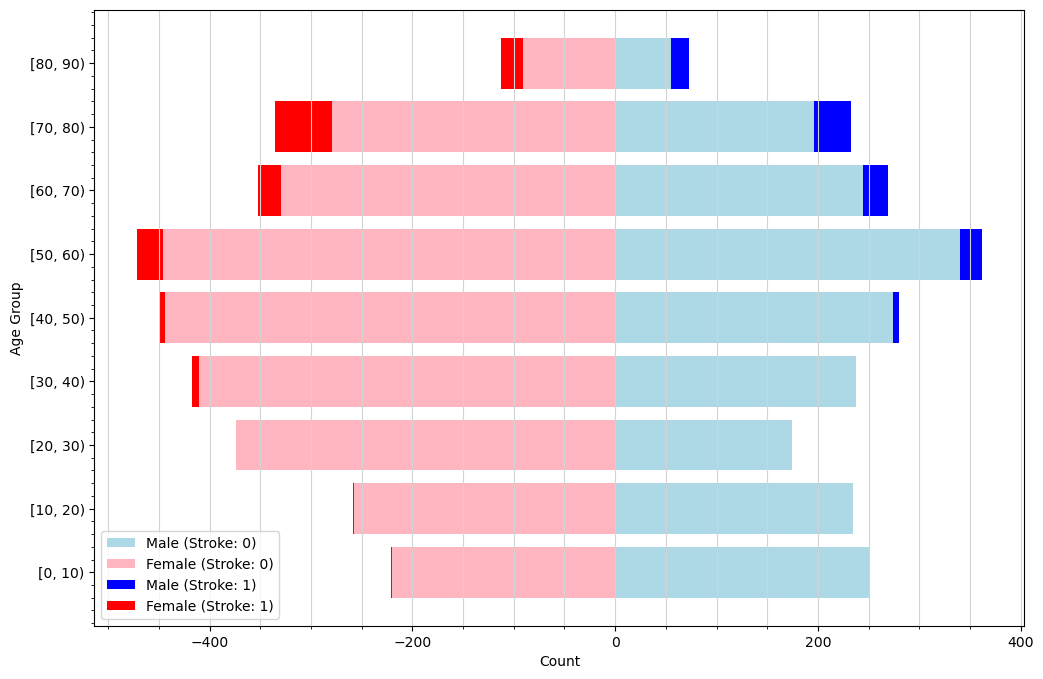

In [10]:
# Defined the age bins
bins = range(0, int(df_2["age"].max()) + 10, 10)

# Add a new column "age_group" to the DataFrame representing the age group of each person
df_2["age_group"] = pd.cut(df_2["age"], bins, right=False)

# Group by "age_group" and "gender" and "stroke" and get the size of each group
grouped = df_2.groupby(["age_group", "gender", "stroke"]).size().unstack(level=[1, 2])

#create pyramid chart
fig, ax = pyplt.subplots(figsize=(12, 8))

#create bar for ech group
for stroke_status in [0, 1]:
    ax.barh(
        grouped.index.astype(str), 
        grouped[("Male", stroke_status)], 
        color='lightblue' if stroke_status == 0 else 'blue', 
        label=f"Male (Stroke: {stroke_status})",
        left=grouped[("Male", 0)] if stroke_status == 1 else 0
    )
    ax.barh(
        grouped.index.astype(str), 
        -grouped[("Female", stroke_status)], 
        color='lightpink' if stroke_status == 0 else 'red', 
        label=f"Female (Stroke: {stroke_status})",
        left=-grouped[("Female", 0)] if stroke_status == 1 else 0
    )


#plot of chart
ax.legend()
ax.minorticks_on()
ax.grid(True, axis="x", color="lightgray", which="both")
pyplt.xlabel("Count")
pyplt.ylabel("Age Group")
pyplt.show()


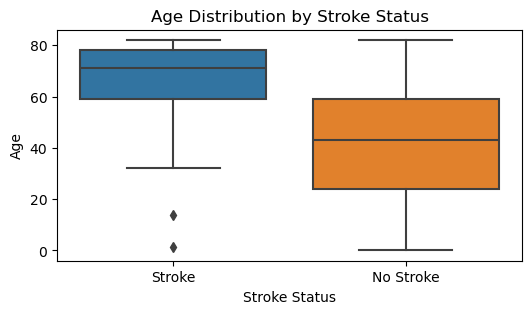

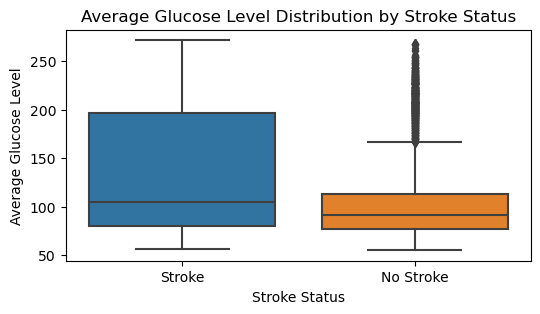

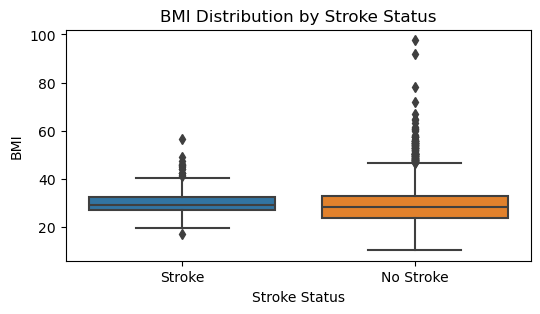

In [11]:
# labels
df_2['stroke_label'] = df_2['stroke'].map({0: 'No Stroke', 1: 'Stroke'})

# Age distribution by stroke status
pyplt.figure(figsize=(6, 3))
sns.boxplot(data=df_2, x='stroke_label', y='age')
pyplt.title('Age Distribution by Stroke Status')
pyplt.xlabel('Stroke Status')
pyplt.ylabel('Age')
pyplt.show()

# Average glucose level distribution by stroke status
pyplt.figure(figsize=(6, 3))
sns.boxplot(data=df_2, x='stroke_label', y='avg_glucose_level')
pyplt.title('Average Glucose Level Distribution by Stroke Status')
pyplt.xlabel('Stroke Status')
pyplt.ylabel('Average Glucose Level')
pyplt.show()

# BMI distribution by stroke status
pyplt.figure(figsize=(6, 3))
sns.boxplot(data=df_2, x='stroke_label', y='bmi')
pyplt.title('BMI Distribution by Stroke Status')
pyplt.xlabel('Stroke Status')
pyplt.ylabel('BMI')
pyplt.show()


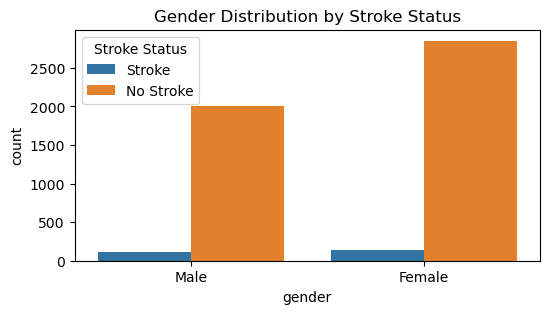

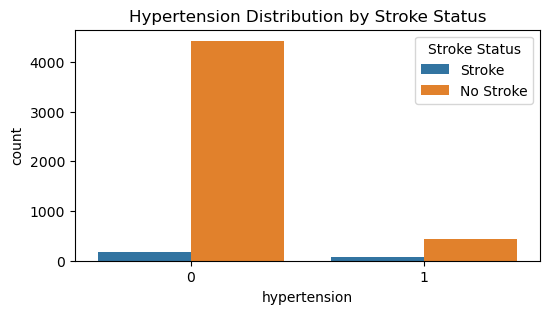

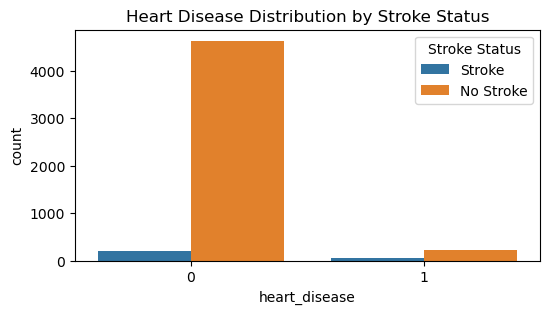

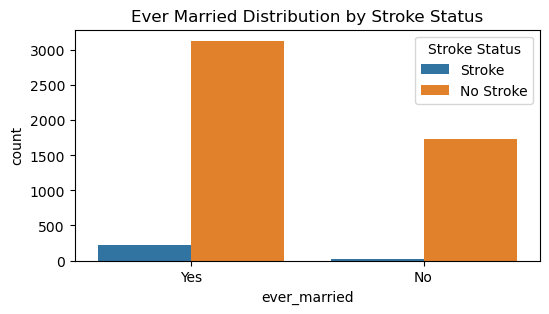

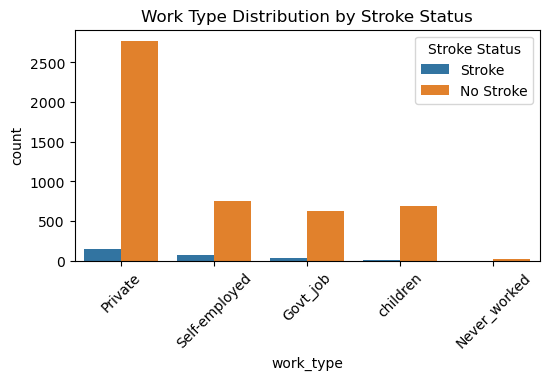

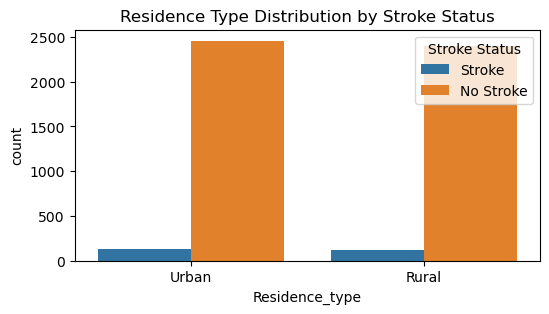

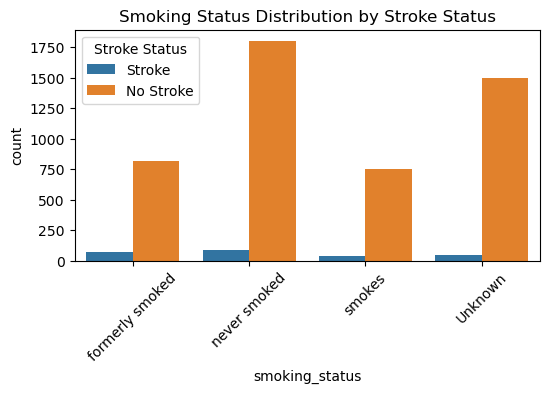

In [12]:
#labels
df_2['stroke_label'] = df_2['stroke'].map({0: 'No Stroke', 1: 'Stroke'})

# Gender distribution by stroke status
pyplt.figure(figsize=(6, 3))
sns.countplot(data=df_2, x='gender', hue='stroke_label')
pyplt.title('Gender Distribution by Stroke Status')
pyplt.legend(title='Stroke Status')
pyplt.show()

# Hypertension distribution by stroke status
pyplt.figure(figsize=(6, 3))
sns.countplot(data=df_2, x='hypertension', hue='stroke_label')
pyplt.title('Hypertension Distribution by Stroke Status')
pyplt.legend(title='Stroke Status')
pyplt.show()

# Heart disease distribution by stroke status
pyplt.figure(figsize=(6, 3))
sns.countplot(data=df_2, x='heart_disease', hue='stroke_label')
pyplt.title('Heart Disease Distribution by Stroke Status')
pyplt.legend(title='Stroke Status')
pyplt.show()

# Ever married distribution by stroke status
pyplt.figure(figsize=(6, 3))
sns.countplot(data=df_2, x='ever_married', hue='stroke_label')
pyplt.title('Ever Married Distribution by Stroke Status')
pyplt.legend(title='Stroke Status')
pyplt.show()

# Work type distribution by stroke status
pyplt.figure(figsize=(6, 3))
sns.countplot(data=df_2, x='work_type', hue='stroke_label')
pyplt.title('Work Type Distribution by Stroke Status')
pyplt.xticks(rotation=45)
pyplt.legend(title='Stroke Status')
pyplt.show()

# Residence type distribution by stroke status
pyplt.figure(figsize=(6, 3))
sns.countplot(data=df_2, x='Residence_type', hue='stroke_label')
pyplt.title('Residence Type Distribution by Stroke Status')
pyplt.legend(title='Stroke Status')
pyplt.show()

# Smoking status distribution by stroke status
pyplt.figure(figsize=(6, 3))
sns.countplot(data=df_2, x='smoking_status', hue='stroke_label')
pyplt.title('Smoking Status Distribution by Stroke Status')
pyplt.xticks(rotation=45)
pyplt.legend(title='Stroke Status')
pyplt.show()


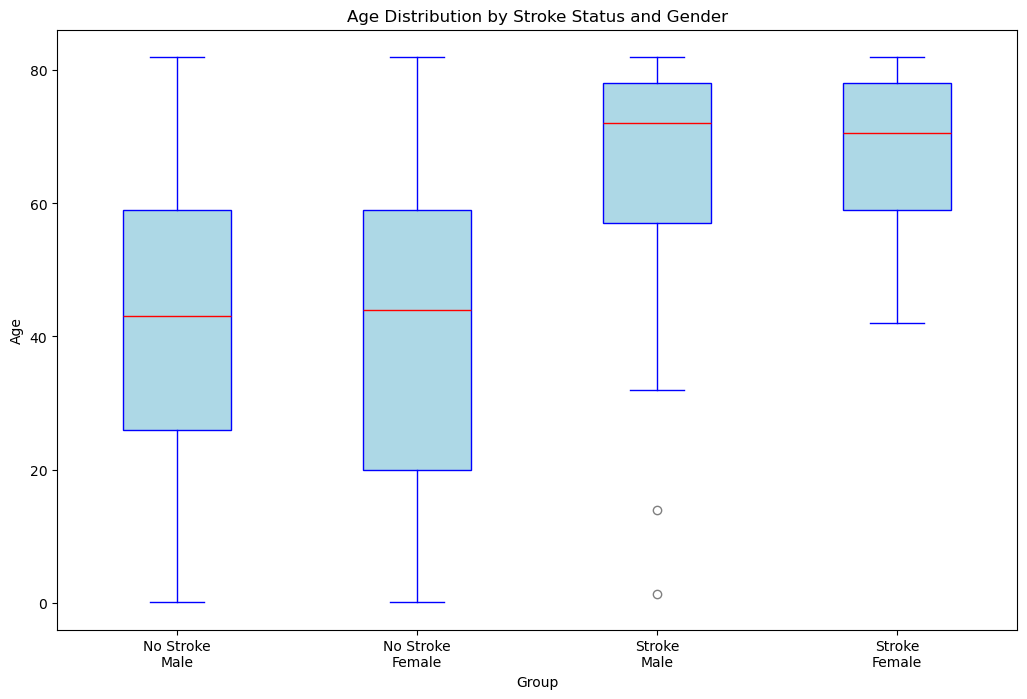

In [13]:

fig, ax = pyplt.subplots(figsize=(12, 8))

#create boxplot
df_2.boxplot(column='age', by=['stroke', 'gender'], ax=ax, grid=False, patch_artist=True, 
             boxprops=dict(facecolor='lightblue', color='blue'),
             medianprops=dict(color='red'),
             whiskerprops=dict(color='blue'),
             capprops=dict(color='blue'),
             flierprops=dict(marker='o', color='blue', alpha=0.5))

#add descriptions
ax.set_title('Age Distribution by Stroke Status and Gender')
ax.set_xlabel('Group')
ax.set_ylabel('Age')
pyplt.suptitle('')

#add x-axis
group_labels = ['No Stroke\nMale', 'No Stroke\nFemale', 'Stroke\nMale', 'Stroke\nFemale']
ax.set_xticklabels(group_labels)

#plot chart
pyplt.show()

c:\Users\LRunge\Anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

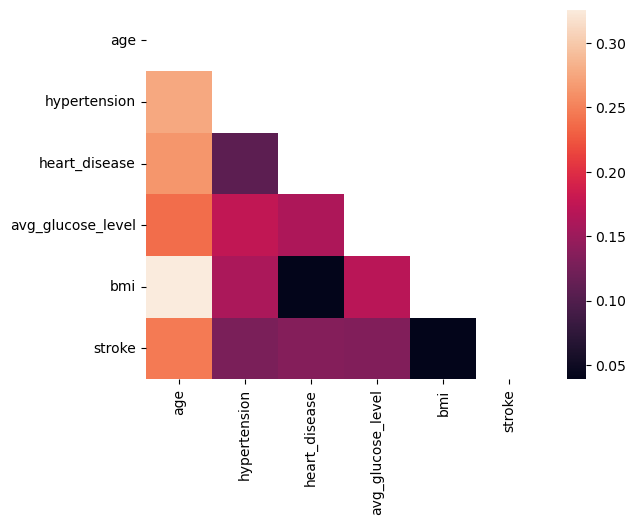

In [14]:
#select only numerical columns to create a heatmap
num_df = df_2.select_dtypes(include=['int64', 'float64'])

#calculate the correlation matrix
corr = num_df.corr()

#plot the heatmap
sns.heatmap(corr, annot=True, mask = np.triu(np.ones_like(corr, dtype=bool)))

c:\Users\LRunge\Anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

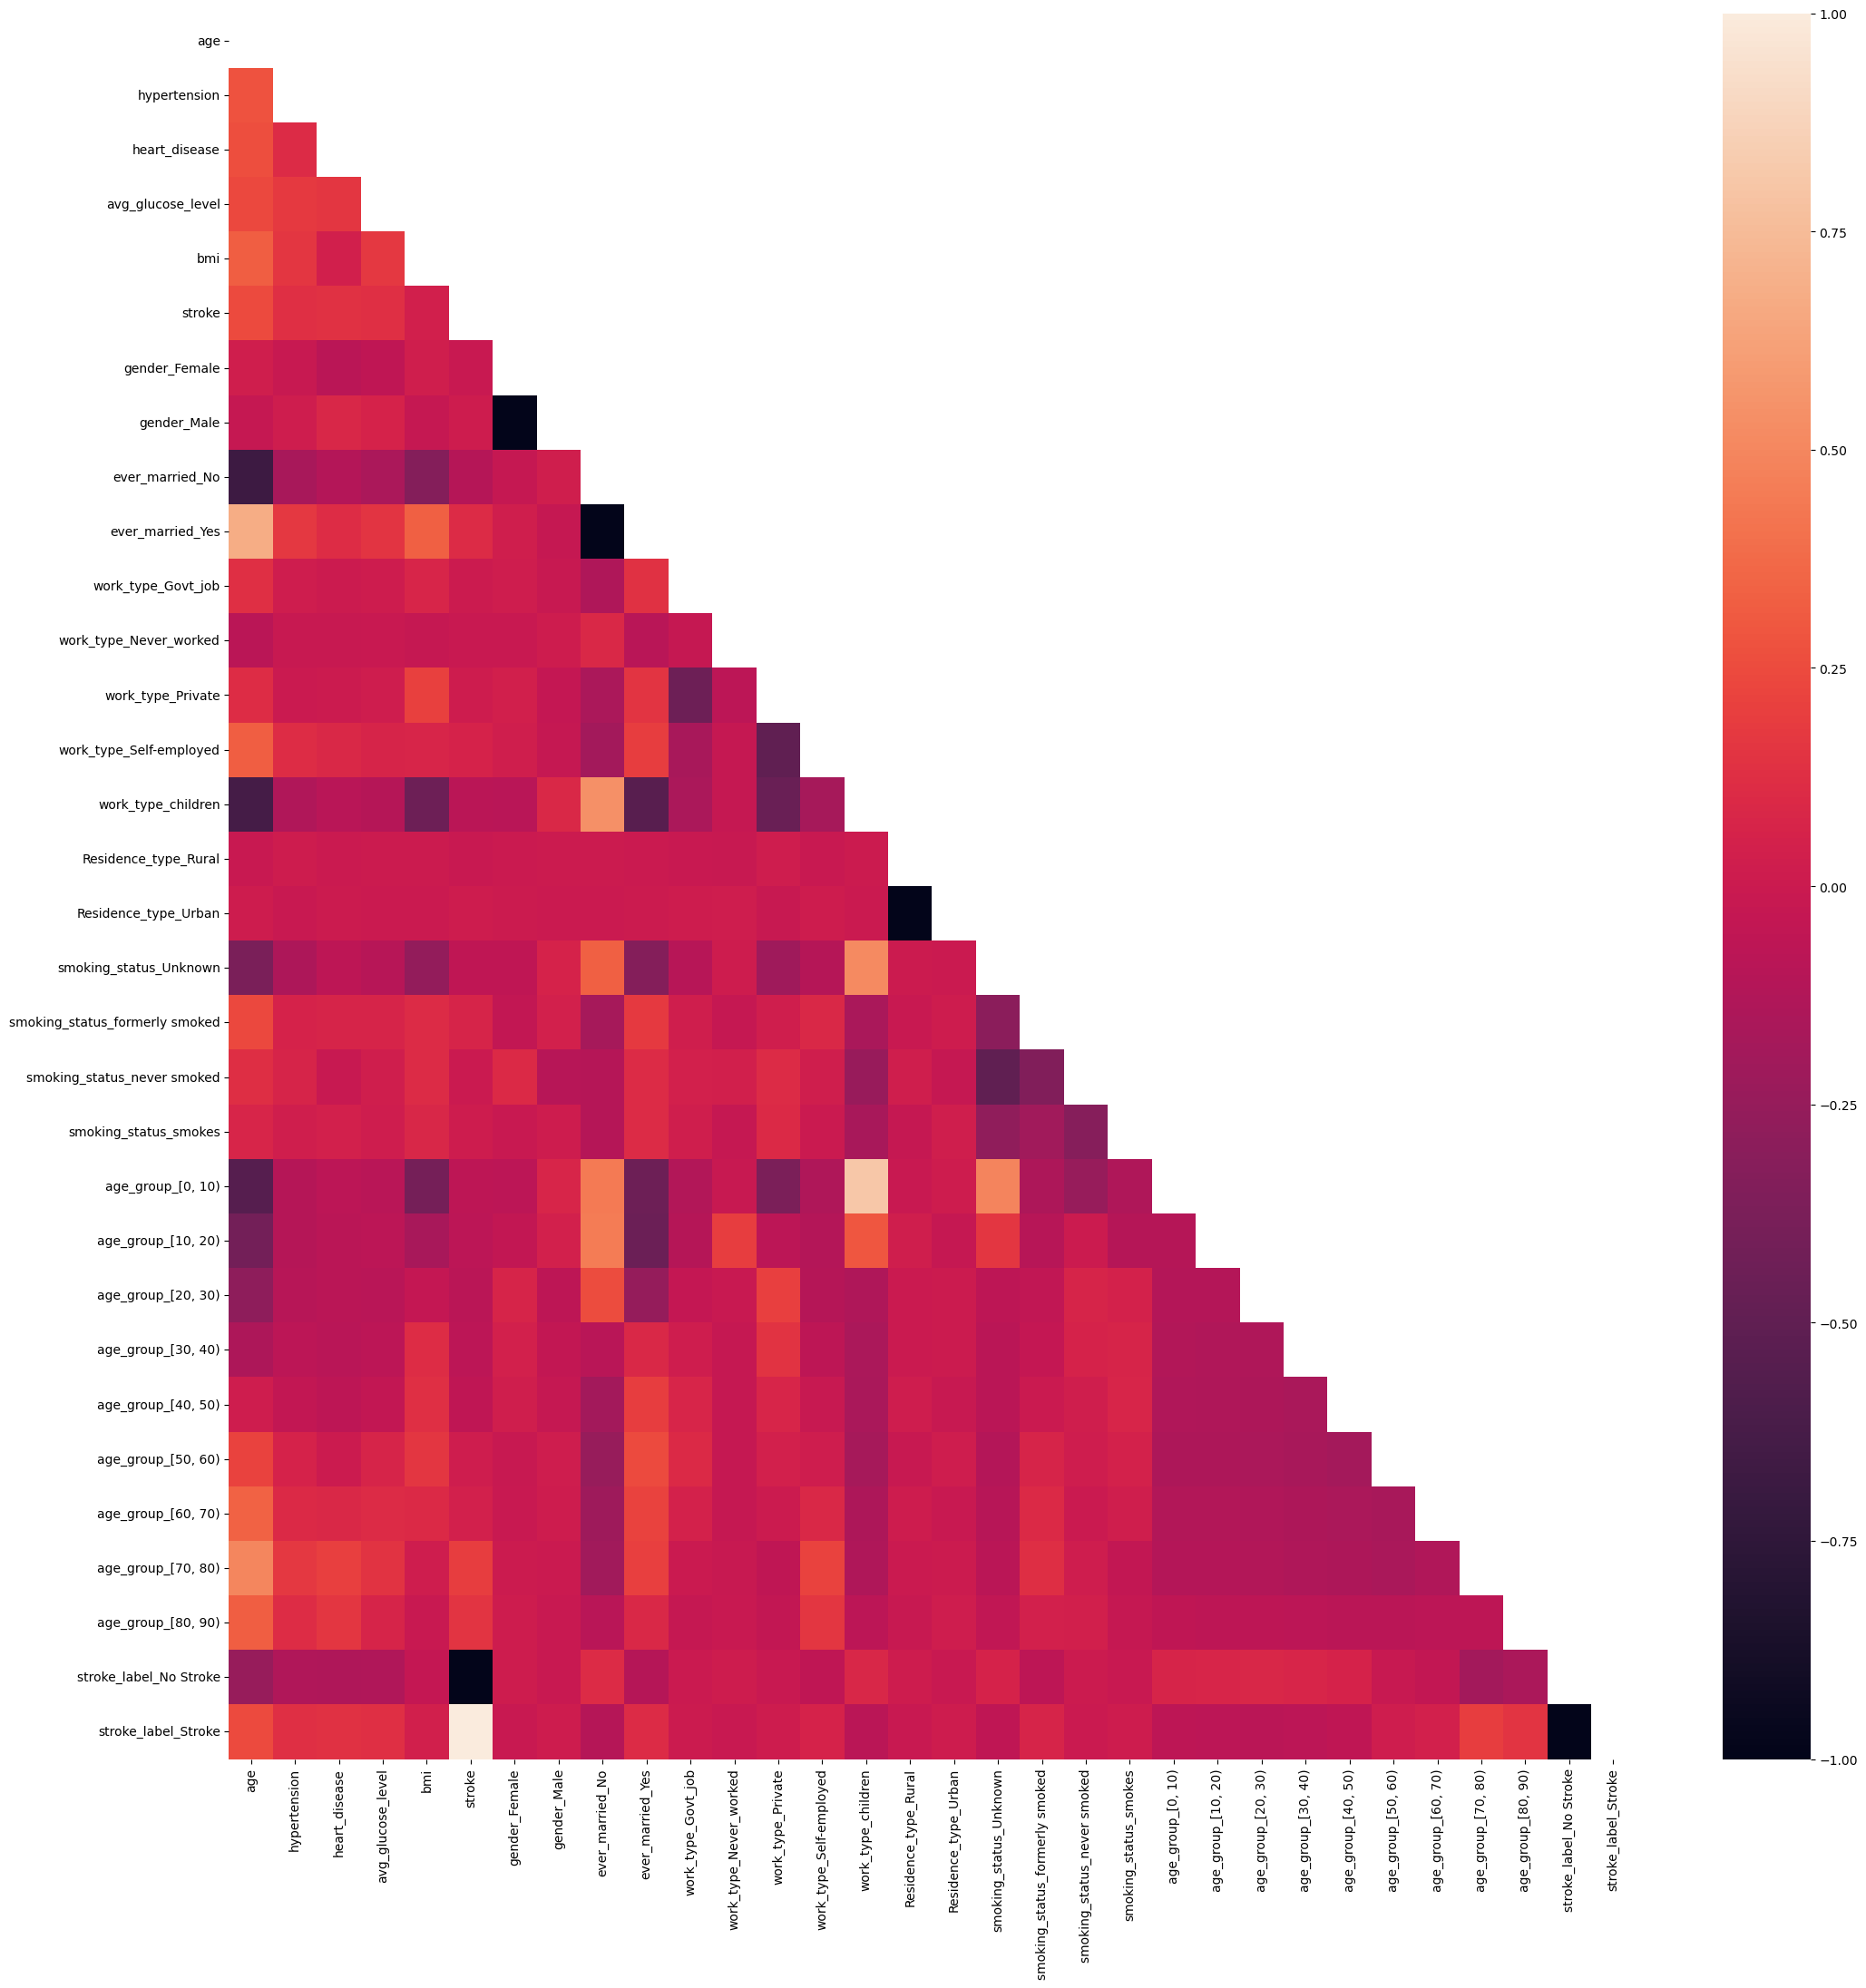

In [15]:
#select only non-numerical columns to create dummies
non_num_df = df_2.select_dtypes(exclude=['int64', 'float64'])

#convert non-numerical columns to dummies
dummies_df = pd.get_dummies(non_num_df)

#convert dummies to integers
dummies_df = dummies_df.astype(int)

#concatenate the numerical and dummies dataframes
completeNum_df = pd.concat([num_df, dummies_df], axis=1)

#calculate the correlation matrix
completeCorr = completeNum_df.corr()

#plot the heatmap
pyplt.figure(figsize=(25, 25))
sns.heatmap(completeCorr, annot=True, mask = np.triu(np.ones_like(completeCorr, dtype=bool)))


In [16]:
stroke_corr = completeCorr['stroke']

# Define a threshold for strong correlation
threshold = 0.05

# Select values where the absolute correlation with 'stroke' is above the threshold
strong_corr = stroke_corr[stroke_corr > threshold]
strong_corr.sort_values(ascending=False, inplace=True)

# Select values where the absolute correlation with 'stroke' is below the threshold
weak_corr = stroke_corr[stroke_corr < threshold]
weak_corr.sort_values(ascending=False, inplace=True)

print(strong_corr)
print("\n")
print(weak_corr)

stroke                            1.000000
stroke_label_Stroke               1.000000
age                               0.245239
age_group_[70, 80)                0.191487
age_group_[80, 90)                0.150139
heart_disease                     0.134905
avg_glucose_level                 0.131991
hypertension                      0.127891
ever_married_Yes                  0.108299
smoking_status_formerly smoked    0.064683
work_type_Self-employed           0.062150
Name: stroke, dtype: float64


age_group_[60, 70)             0.046553
bmi                            0.038917
age_group_[50, 60)             0.018085
Residence_type_Urban           0.015415
work_type_Private              0.011927
gender_Male                    0.009081
smoking_status_smokes          0.008920
work_type_Govt_job             0.002660
smoking_status_never smoked   -0.004163
gender_Female                 -0.009081
work_type_Never_worked        -0.014885
Residence_type_Rural          -0.015415
smoking_status_U

In [17]:
z_scores = np.abs(stats.zscore(num_df))

threshold = 3

outliers = num_df[(z_scores > threshold).any(axis=1)]

print(outliers)

       age  hypertension  heart_disease  avg_glucose_level       bmi  stroke
0     67.0             0              1             228.69  36.60000       1
1     61.0             0              0             202.21  28.89456       1
2     80.0             0              1             105.92  32.50000       1
3     49.0             0              0             171.23  34.40000       1
4     79.0             1              0             174.12  24.00000       1
...    ...           ...            ...                ...       ...     ...
5088  64.0             1              0              76.89  30.20000       0
5091  59.0             1              0              95.05  30.90000       0
5093  45.0             1              0              95.02  28.89456       0
5100  82.0             1              0              71.97  28.30000       0
5105  80.0             1              0              83.75  28.89456       0

[930 rows x 6 columns]


### Medizinische Risikofaktoren 

Aus dem Auszug aus "Der Nervenarzt" (Weih, M., Müller-Nordhorn, J., Amberger, N., Masuhr, F., Lürtzing, F., Dreier, J. P., & Hetzel, A. (2004). Risikofaktoren des ischämischen Schlaganfalls. Der Nervenarzt, 75(4), 324-335.) gehen folgende Risikofaktoren für einen Schlaganfall hervor:


[Hier ist das Dokument verlinkt](https://d1wqtxts1xzle7.cloudfront.net/94400450/s00115-003-1639-620221117-1-1gmosza-libre.pdf?1668693481=&response-content-disposition=inline%3B+filename%3DRisikofaktoren_des_isch_mischen_Schlagan.pdf&Expires=1717179362&Signature=bGb58O9nASWfgCQqpNkQFhmIHglmKAvrY3kmiZBI3tDAi1DlG~VZKiIfktxvCrA0xkuwOhSPU06fMT0U7xKca0pYi2KamjsU3aM9pTJE-jotX7kzQ3rEVYaYzT-BdPSRK2uY4-j2-jQSbrxPOgs0P53mV1YWwopvOcYulQYx0caoDckv1LegUKDGacm6Fd2s0bmvyJO7-11wJOvM2iasaOvPofmJhggWYMWB~~zC4JHON4Kz8XYNrcW3g2ywKfwVX0U2NgCOxHdJ26YFsaLNm~ebMgrEHipW5WF-VFHvR89ro605zx0J5UFukRoP3beZ2abSw8z2lnFyoF9MKRLPzg__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)



##### Risikofaktoren für Schlaganfälle: (S.334 f)

1. **Hypertonie**: Aufgrund ihrer hohen Prävalenz und ihres starken Einflusses auf das Schlaganfallrisiko ist Hypertonie einer der bedeutendsten Risikofaktoren.


2. **Vorhofflimmern**: Die Antikoagulation bei Vorhofflimmern kann das Schlaganfallrisiko signifikant reduzieren.


3. **Atherosklerose-bezogene Risikofaktoren**: Dazu gehören hohe Cholesterinwerte, die vor allem für atherothrombotische Infarkte relevant sind. Statine können das Schlaganfallrisiko bei Patienten mit KHK oder Hypercholesterinämie reduzieren.


4. **Verhaltensabhängige Lebensstilfaktoren**: Rauchen, Übergewicht, körperliche Inaktivität und ungesunde Ernährung sind ebenfalls wichtige Risikofaktoren, die durch Interventionen modifiziert werden können.


5. **Kardiale Risikofaktoren**: Dazu gehören persistierendes Foramen ovale, Herzinsuffizienz und koronare Herzkrankheit, die das Schlaganfallrisiko erhöhen können.


6. **Gerinnungsstörungen**: Obwohl das Evidenzniveau und das Verständnis dieser Risikofaktoren heterogen sind, können Gerinnungsstörungen wie APC-Resistenz, Antiphospholipid-Antikörper, Hyperhomozysteinämie und Hyperfibrinogenämie das Risiko erhöhen. 


7. **Weitere Risikofaktoren**: Dazu gehören Migräne, orale Kontrazeptiva, Entzündungen (z.B. durch CRP) und möglicherweise Infektionen (z.B. durch Chlamydien oder Helicobacter).

Text(0.5, 1.0, 'Stroke: No')

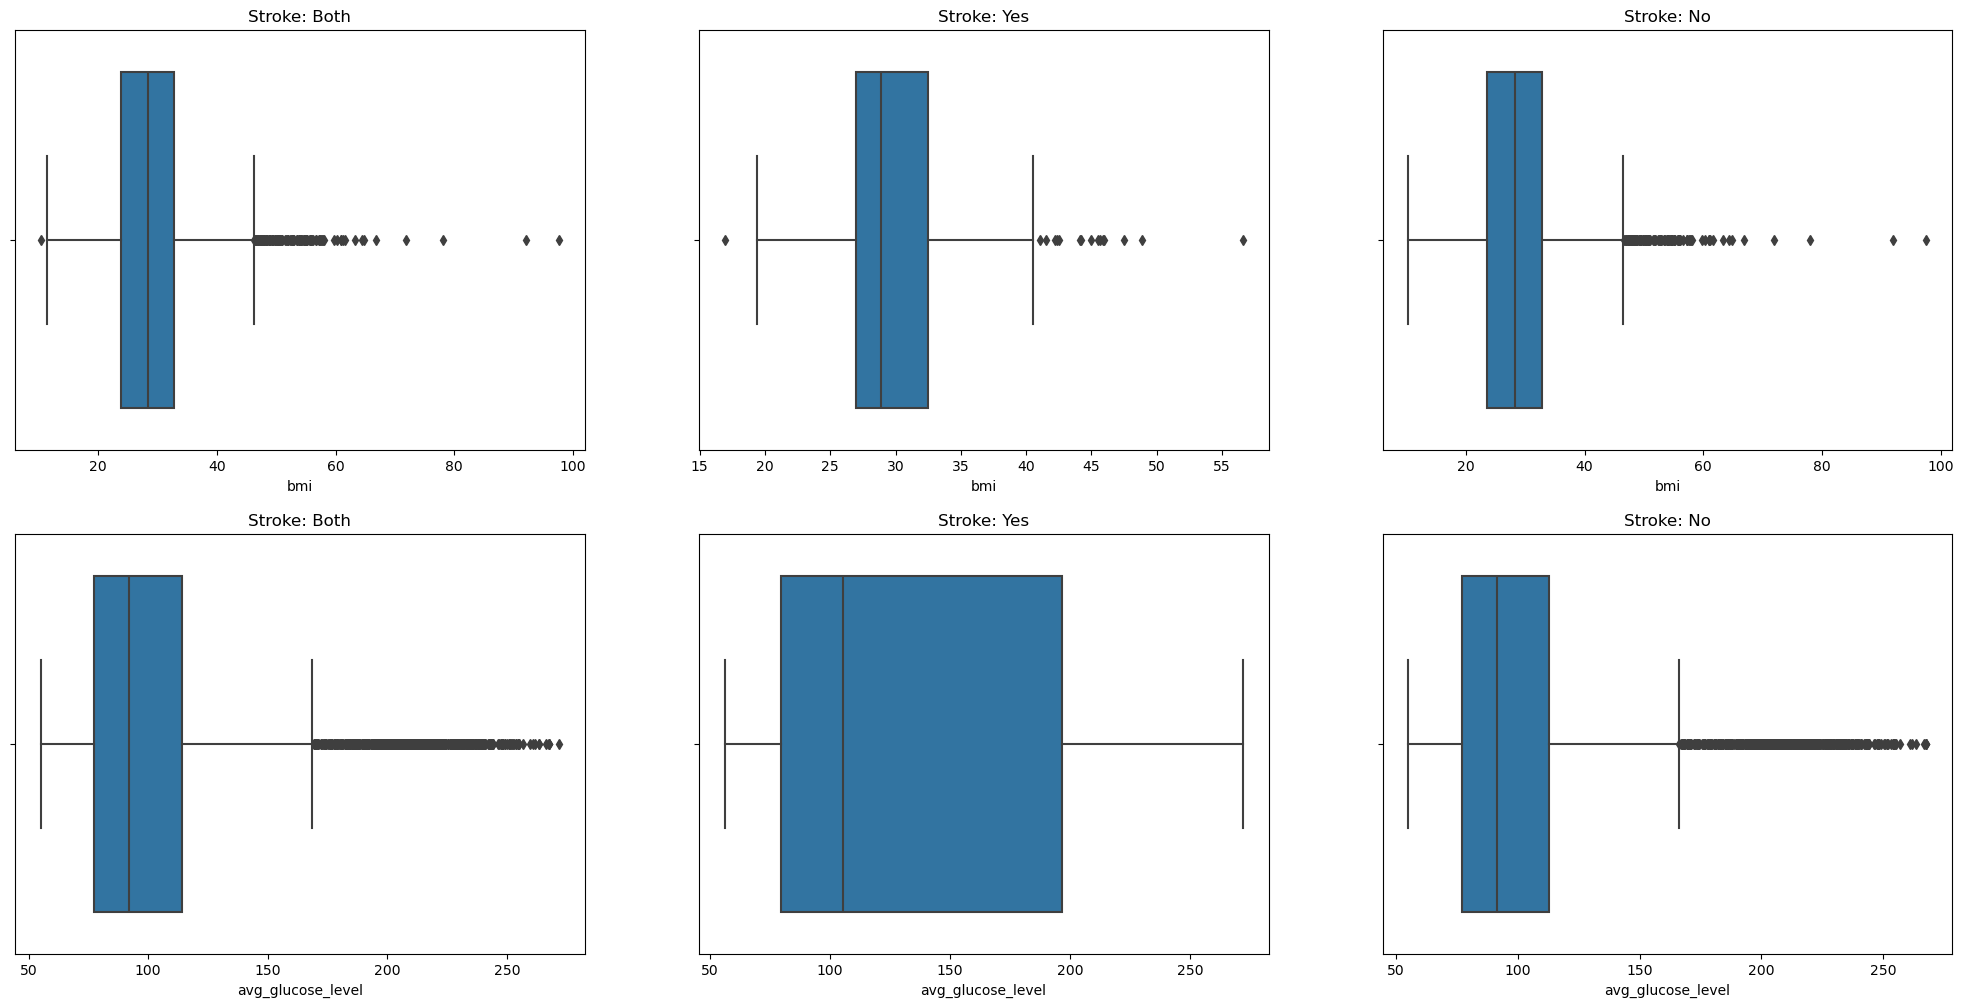

In [18]:
stroke_yes = df_2[df_2['stroke'] == 1]
stroke_no = df_2[df_2['stroke'] == 0]

fig, ax = pyplt.subplots(nrows=2, ncols=3, figsize=(25, 12))	

sns.boxplot(x=df_2['bmi'], ax=ax[0,0])
ax[0,0].set_title('Stroke: Both')

sns.boxplot(x=stroke_yes['bmi'], ax=ax[0,1])
ax[0,1].set_title('Stroke: Yes')

sns.boxplot(x=stroke_no['bmi'], ax=ax[0,2])
ax[0,2].set_title('Stroke: No')

sns.boxplot(x=df_2['avg_glucose_level'], ax=ax[1,0])
ax[1,0].set_title('Stroke: Both')

sns.boxplot(x=stroke_yes['avg_glucose_level'], ax=ax[1,1])
ax[1,1].set_title('Stroke: Yes')

sns.boxplot(x=stroke_no['avg_glucose_level'], ax=ax[1,2])
ax[1,2].set_title('Stroke: No')

Text(0.5, 1.0, 'Stroke: No')

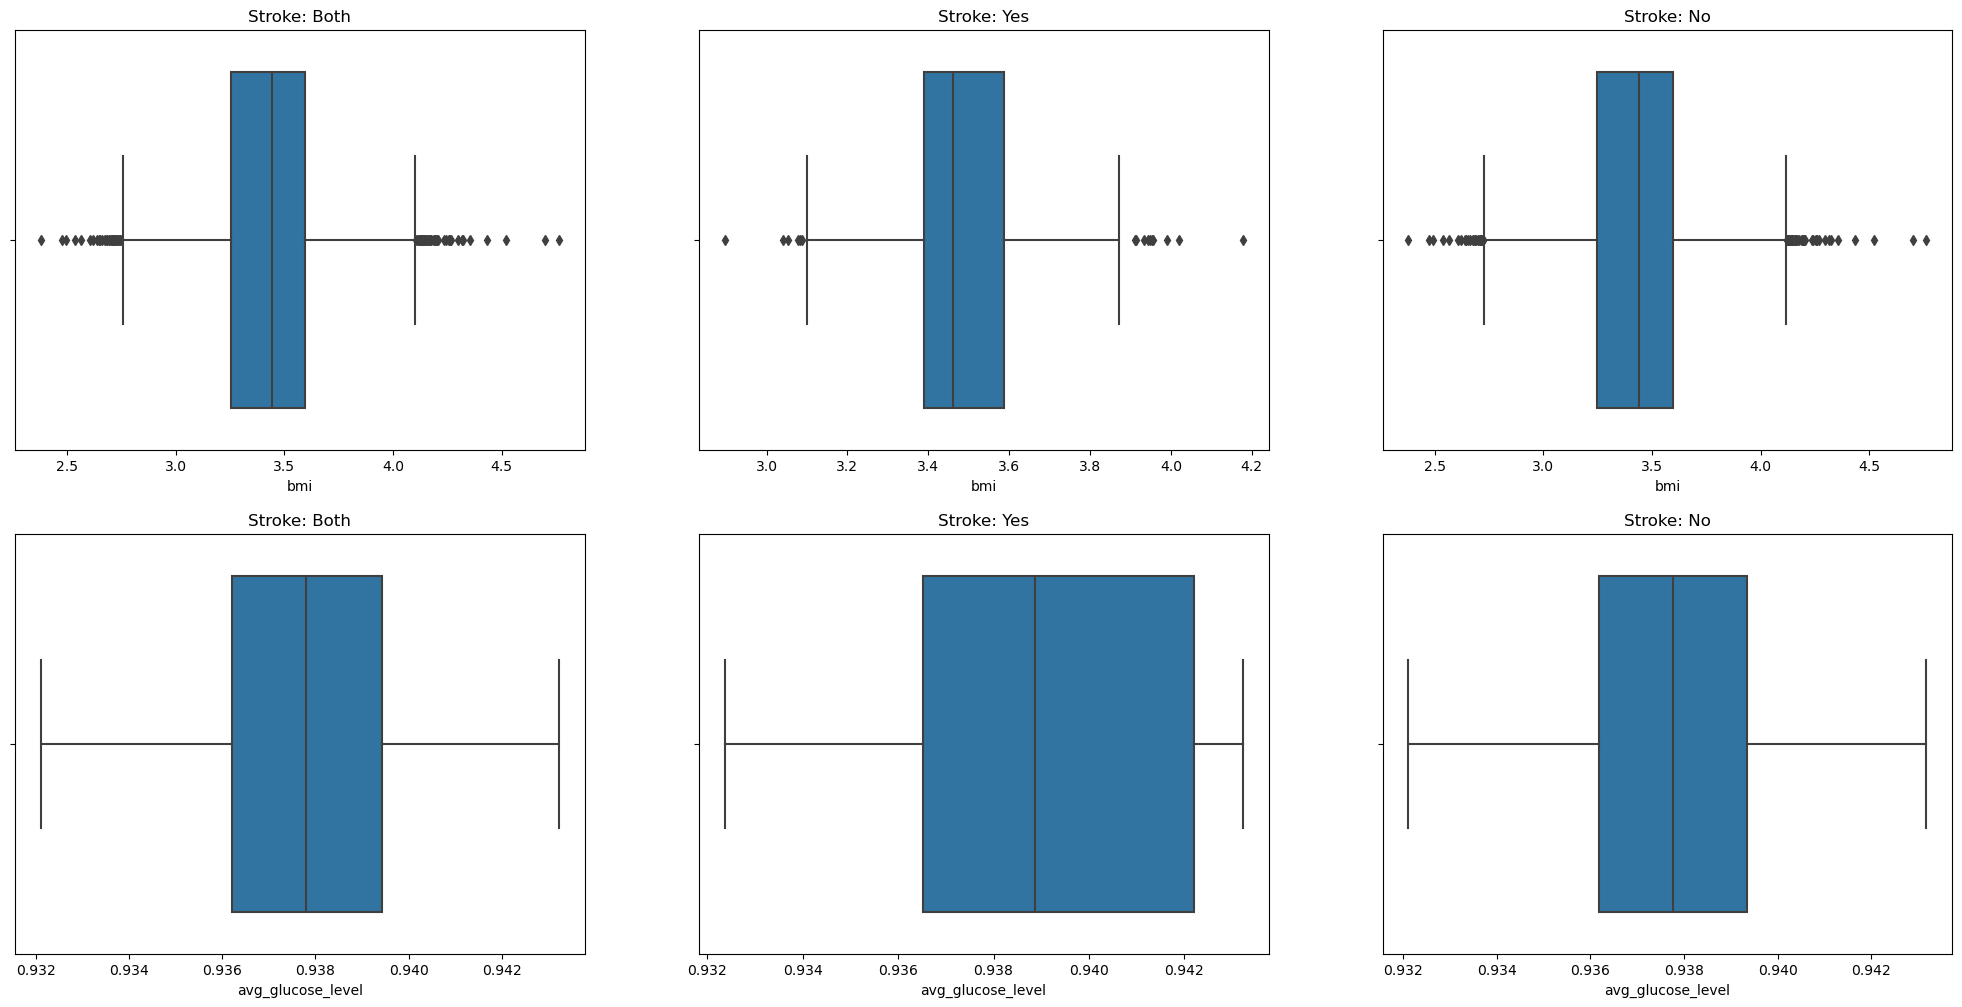

In [19]:
df_nml = df_2.drop(["age_group", "stroke_label"], axis=1)	

pt = PowerTransformer(method='box-cox', standardize=False, copy=False)

# Transformation der Daten
df_nml[['bmi', 'avg_glucose_level']] = pt.fit_transform(df_nml[['bmi', 'avg_glucose_level']])

df_nml

stroke_yes = df_nml[df_nml['stroke'] == 1]
stroke_no = df_nml[df_nml['stroke'] == 0]

fig, ax = pyplt.subplots(nrows=2, ncols=3, figsize=(25, 12))	

sns.boxplot(x=df_nml['bmi'], ax=ax[0,0])
ax[0,0].set_title('Stroke: Both')

sns.boxplot(x=stroke_yes['bmi'], ax=ax[0,1])
ax[0,1].set_title('Stroke: Yes')

sns.boxplot(x=stroke_no['bmi'], ax=ax[0,2])
ax[0,2].set_title('Stroke: No')

sns.boxplot(x=df_nml['avg_glucose_level'], ax=ax[1,0])
ax[1,0].set_title('Stroke: Both')

sns.boxplot(x=stroke_yes['avg_glucose_level'], ax=ax[1,1])
ax[1,1].set_title('Stroke: Yes')

sns.boxplot(x=stroke_no['avg_glucose_level'], ax=ax[1,2])
ax[1,2].set_title('Stroke: No')

<h3>4Balancing<h3>

In [20]:

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


In [21]:
df_nml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in categorical_cols:
    df_nml[i] = le.fit_transform(df_nml[i])
    l3.append(list(df_nml[i].unique())); l4.append(list(le.inverse_transform(df_nml[i].unique())))
    print(i,' : ',df_nml[i].unique(),' = ',le.inverse_transform(df_nml[i].unique()))

Label Encoder Transformation
gender  :  [1 0]  =  ['Male' 'Female']
ever_married  :  [1 0]  =  ['Yes' 'No']
work_type  :  [2 3 0 4 1]  =  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type  :  [1 0]  =  ['Urban' 'Rural']
smoking_status  :  [1 2 3 0]  =  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [23]:
df_nml.head()   

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,0.942715,3.712272,1,1
1,0,61.0,0,0,1,3,0,0.942294,3.461491,2,1
2,1,80.0,0,1,1,2,0,0.938910,3.586108,2,1
3,0,49.0,0,0,1,2,1,0.941631,3.646411,3,1
4,0,79.0,1,0,1,3,0,0.941703,3.265300,2,1


In [24]:
features = df_nml.drop("stroke", axis=1)
target = df_nml["stroke"]

under_sampler = RandomUnderSampler(sampling_strategy=0.075)
smote = SMOTE(sampling_strategy=1)


features_under, target_under = under_sampler.fit_resample(features, target)

features_balanced, target_balanced = smote.fit_resample(features_under, target_under)

Counter(target_balanced)



Counter({0: 3320, 1: 3320})

In [25]:
features_balanced.to_csv('Data/Features.csv', index=False)

In [26]:
one change

SyntaxError: invalid syntax (84651764.py, line 1)